# Lecture 6 Exercises solutions

## In class, FD exercise:

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 81
ny = 81
nt = 100
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
print("dx %s, dy %s" % (dx, dy))
sigma = .2
dt = sigma * dx

dx 0.025, dy 0.025


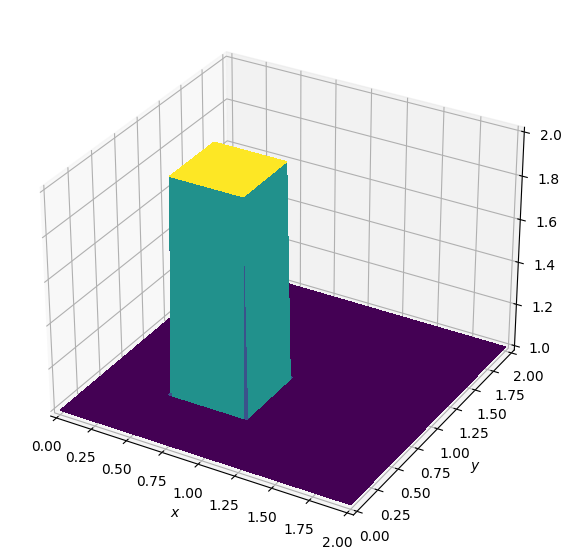

In [2]:
# Create field and assign initial conditions
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=2.)

# Plot initial condition
plot_field(u)

In [3]:
# Repeat initialisation, so we can re-run the cell
init_hat(field=u, dx=dx, dy=dy, value=2.)

for n in range(nt + 1):
    # Copy previous result into a new buffer
    un = u.copy()
    
    # Update the new result with a 3-point stencil
    u[1:, 1:] = (un[1:, 1:] - (c * dt / dy * (un[1:, 1:] - un[1:, :-1])) -
                              (c * dt / dx * (un[1:, 1:] - un[:-1, 1:])))

    # Apply boundary conditions. 
    u[0, :] = 1.  # left
    u[-1, :] = 1. # right
    u[:, 0] = 1.  # bottom
    u[:, -1] = 1. # top
    # Note that in the above expressions the NumPy index -1 corresponds to the final point of the array along the indexed dimension, 
    #    i.e. here u[-1, :] is equivalent to u[80, :].

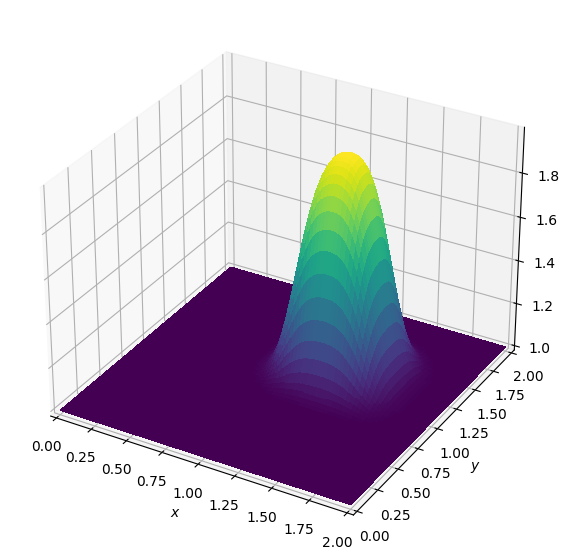

In [4]:
# A small sanity check for auto-testing
assert (u[45:55, 45:55] > 1.8).all()
u_ref = u.copy()
plot_field(u)

# Exercise 1:

An exact traveling wave solution to the 1-dimensional wave-equation,
$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0,$$
on the interval $x\in[0,1]$ with $c=1$ is given by:
$$u(x,t)=\left[\mathrm{max}(0,4\zeta(1-\zeta))\right]^{12},$$
where
$$\zeta=4(x-ct)-1,$$
subject to the boundary conditions $u(0,t)=u(1,t)=0$. A potential Devito implementation is outlined below.

In [5]:
import numpy as np
from devito import Function, solve, Grid

# Python functions to compute the initial condition:
def compute_zeta(x,t):
    return 4.0*(x-t)-1.0

def compute_u(x,t):
    u1 = 4.0*compute_zeta(x,t)*(1.0-compute_zeta(x,t))
    u2 = np.zeros(u1.shape)
    return (np.maximum(u1,u2))**(12)

# define spatial mesh
# Size of rectangular domain
Lx = 1

# Number of grid points in each direction, including boundary nodes
Nx = 201

# hence the mesh spacing
dx = Lx/(Nx-1)

x = np.linspace(0,Lx,Nx)

grid = Grid(shape=(Nx), extent=(Lx))

# Initial condition
u_0 = Function(name='u_0', grid=grid)
u_0.data[:] = compute_u(x,0)

# We'll need one of these for composing the boundary conditions:
t = grid.stepping_dim
time = grid.time_dim

In [6]:
# Devito implementation

# Required imports
from devito import TimeFunction, Eq, Operator

# Define the grid/computational domain

# Wavefield
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=4)

# Time-step
dt = 0.001

# Define the equation and boundary conditions (with c=1)
pde = u.dt2-u.dx2
eq = Eq(u.forward, solve(pde, u.forward))
bc = [Eq(u[t+1, 0], 0)]
bc += [Eq(u[t+1, Nx-1], 0)]

# Set the initial conditions
u.data[0,:] = u_0.data[:]
u.data[1,:] = compute_u(x,dt)

# Create the Devito Operator
op = Operator([eq]+bc)

In [7]:
op.apply(time_m=1, time_M=1999, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.00019699999999999956, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

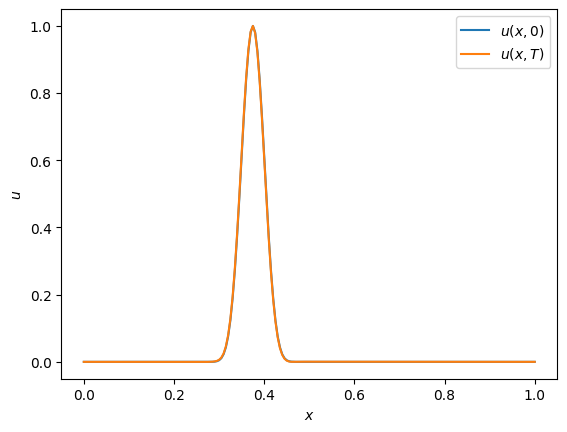

In [8]:
# Plot the initial condition and final condition

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, u_0.data[:], label = "$u(x,0)$")
plt.plot(x, u.data[0, :], label = "$u(x,T)$")
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.show()

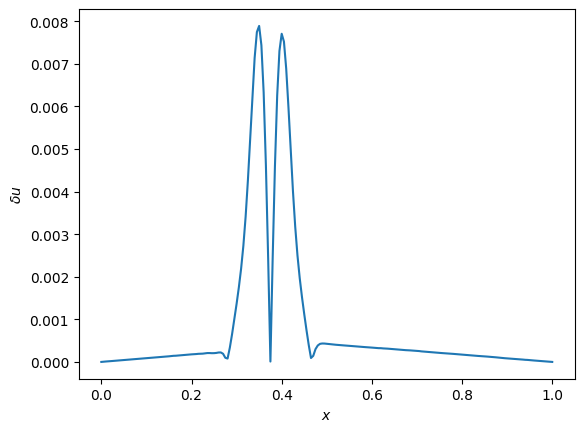

In [9]:
# Plot the residual

%matplotlib inline

plt.plot(x, np.abs(u_0.data[:]-u.data[0, :]))
plt.xlabel('$x$')
plt.ylabel('$\delta u$')
plt.show()

You can now play around with some parameters and reduce the residual.

## Exercise 2:

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="figures/exact_solution.png" width="450" height="450" align="center"/>

The exact solution can be written as:
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

From analysing the exact solution, we can see that the wave will return to it's initial position (for the first time) when

\begin{equation*}
 \frac{cT\pi}{10}=2\pi,
\end{equation*}

and hence the period $T=20/c$. We'll run our simulation forward to this time for comparison.

A potential Devito implementation is outlined below (note that this is similar to the previous exercise):

In [10]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

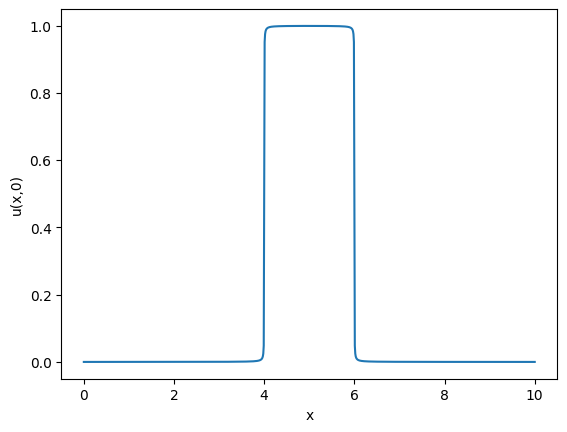

In [11]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

In [12]:
# Devito implimentation

time_order = 2
space_order = 2

In [13]:
# Required imports
from devito import Grid, TimeFunction, Eq, solve, Operator

# Define the grid/computational domain
grid = Grid(shape=(l), extent=(L))
t_s = grid.stepping_dim

# Wavefield
u = TimeFunction(name='u', grid=grid, time_order=time_order, space_order=space_order)

dx = abs(x[1]-x[0])
# Critical time-step
dt = 0.004 # (dt < 0.42*dx/c)

# Define the equation and boundary conditions
pde = 1/c**2*u.dt2-u.dx2
eq = Eq(u.forward, solve(pde, u.forward))
bc = [Eq(u[t_s+1, 0], 0)]
bc += [Eq(u[t_s+1, -1], 0)]

# Set the initial conditions
u0 = u_e(x, 0)
u1 = u_e(x, dt)
u.data[0,:] = u0
u.data[1,:] = u1

# Create the Devito Operator
op = Operator([eq]+bc)

In [14]:
# Now lets run the operator - by choosing time_M=4999 our final result will be from t=20.
op.apply(time_m=1, time_M=4999, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.004356000000000171, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

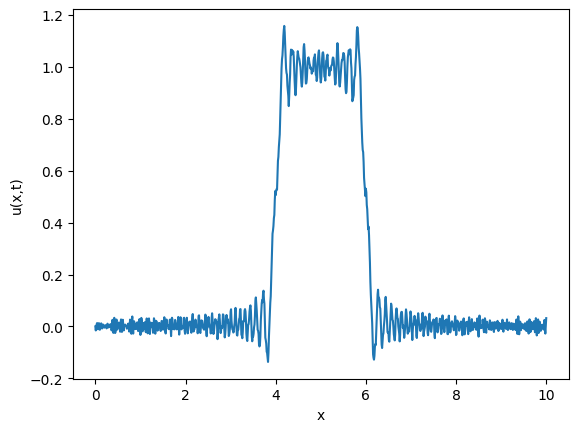

In [15]:
%matplotlib inline
# Lets plot some Devito results:
plt.plot(x, u.data[mod(5000,3), :])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

The above result isn't terrible but there's been quite a bit of numerical dispersion. How do you think we can improve it? We can increase the resolution, increase the space order of our discretisation etc. Try playing around with these things to see what you come up. Another big improvement can be found by improving our time stepping scheme so, although a little more involved, that's something you could also play around with.

Note that a pure python implementation has not been given here but from looking at the c-code Devito produces it's easy to see how one could be achieved:

In [16]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
  void * dmap;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict u_vec, const float dt, const float h_x, const int time_M, const int time_m, const int x_M, const int x_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]]) u_vec->data;

  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DE